In [1]:
pip install langchain

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install langchain_community

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ollama

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U langchain-ollama

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_ollama import OllamaLLM

In [6]:
llm = OllamaLLM(model="newtest")
import pandas as pd
import re 
import asyncio

In [7]:
ff1 = pd.read_csv("train_data_only_messages.csv")


In [16]:
from tqdm import tqdm
def convert_all_comments_to_strings(ff1):
    comments_list = ff1['comment_text'].astype(str).tolist()
    return comments_list
all_comments_as_strings = convert_all_comments_to_strings(ff1)
k=0
data_list = []
for k in tqdm(range(0, 31915)):
    answer = llm.invoke(all_comments_as_strings[k])
    data = {'comment_text': all_comments_as_strings[k]}
    k += 1
    
    matches = re.findall(r'(\w+):\s*(yes|no)', answer)
    for label, value in matches:
        data[label] = value
            
    data_list.append(data)


        
answers_df = pd.DataFrame(data_list)


100%|██████████| 31915/31915 [3:56:26<00:00,  2.25it/s]      


In [15]:
answers_df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Shazbot now your lieing you already stated you...,no,no,no,no,no,no


In [11]:
from tqdm import tqdm
def convert_all_comments_to_strings(ff1):
    return ff1['comment_text'].astype(str).tolist()

all_comments_as_strings = convert_all_comments_to_strings(ff1)

def extract_categories(answer):
    # Задаємо список категорій у потрібному порядку
    categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    result = {}
    for cat in categories:
        # Шукаємо шаблон: назва категорії, опціональні пробіли, двокрапка, опціональні пробіли, число (0 або 1)
        pattern = r"{0}\s*:\s*(\d)".format(cat)
        match = re.search(pattern, answer, re.IGNORECASE)
        if match:
            result[cat] = int(match.group(1))
        else:
            # Якщо категорія не знайдена, повертаємо порожній рядок
            result[cat] = ""
    return result

def get_answer_with_timeout(comment, timeout=1):
    # Використовуємо ThreadPoolExecutor для виконання виклику з таймаутом
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(llm.invoke, comment)
        try:
            answer = future.result(timeout=timeout)
        except concurrent.futures.TimeoutError:
            # Якщо відповідь не отримано протягом timeout секунд, повертаємо порожній рядок
            answer = ""
    return answer


data_list = []
# Перебираємо повідомлення з індексами від 31900 до 31950
for k in tqdm(range(0, 31915), desc="Processing comments"):
    answer = get_answer_with_timeout(all_comments_as_strings[k], timeout=1)
    print("------------------------")
    print("answer :", answer)
    data = {"comment_text": all_comments_as_strings[k]}
    # Отримуємо значення для заданих категорій
    cat_values = extract_categories(answer)
    data.update(cat_values)
    data_list.append(data)

# Створюємо DataFrame із зібраних даних
answers_df = pd.DataFrame(data_list)

# (Опціонально) зберегти результат у CSV:
answers_df.to_csv("output.csv", index=False)



rocessing comments:   0%|          | 0/31915 [00:00<?, ?it/s]

NameError: name 'concurrent' is not defined

In [17]:
answers_df.to_csv("test_pred.csv", index=False)

In [30]:
print(type(data))

<class 'dict'>


In [ ]:
import pandas as pd
df = pd.read_csv("test_pred.csv")
column_mapping = {
    "toxic": "toxic",
    "severe_toxic": "severe_toxic",
    "obscene": "obscene",
    "threat": "threat",
    "insult": "insult",
    "identity_hate": "identity_hate"
}

# Перейменування стовпців
df = df.rename(columns=column_mapping)

columns_to_convert = ["toxic", "severe_toxic", "obscene","threat","insult","identity_hate"]  # Вкажіть потрібні стовпці
for col in columns_to_convert:
    df[col] = df[col].map({"yes": 1, "no": 0})

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
df.to_csv('test_pred_modified.csv', index=False)

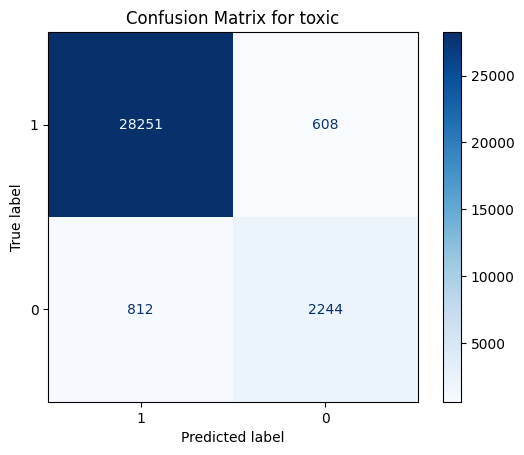

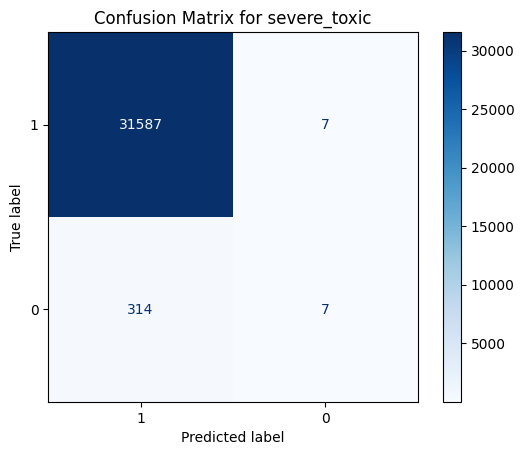

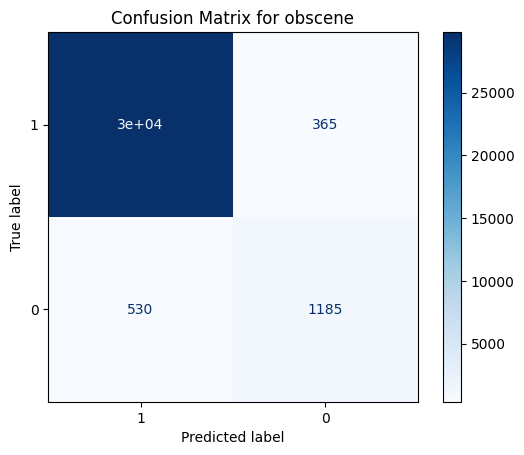

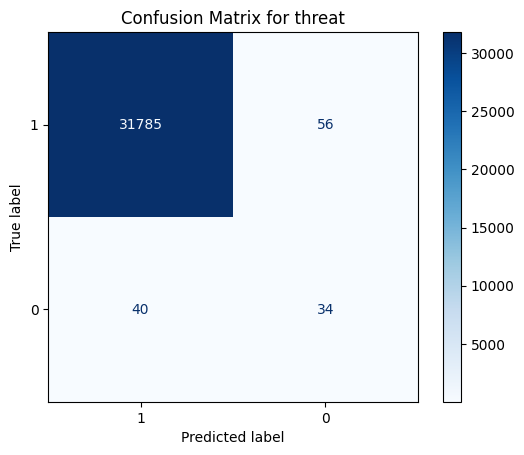

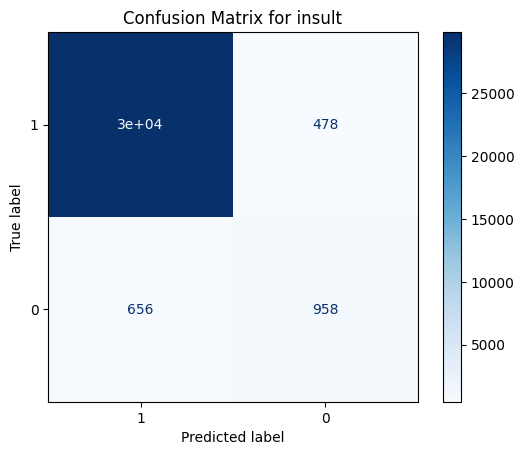

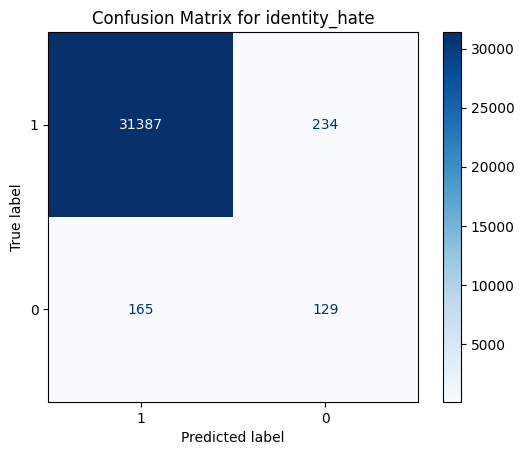

Multi-label Confusion Matrices:
 [[[28251   608]
  [  812  2244]]

 [[31587     7]
  [  314     7]]

 [[29835   365]
  [  530  1185]]

 [[31785    56]
  [   40    34]]

 [[29823   478]
  [  656   958]]

 [[31387   234]
  [  165   129]]]


In [35]:
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

test_data_path = 'test.csv'  # true labels
test_my_path = 'test_pred_modified.csv'  # predicted labels

test_data = pd.read_csv(test_data_path)
test_my = pd.read_csv(test_my_path)


columns_to_compare = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


true_labels = test_data[columns_to_compare].fillna(0).astype(int).values
predicted_labels = test_my[columns_to_compare].fillna(0).astype(int).values

ml_cm = multilabel_confusion_matrix(true_labels, predicted_labels)

for idx, column in enumerate(columns_to_compare):
    disp = ConfusionMatrixDisplay(confusion_matrix=ml_cm[idx], display_labels=[1, 0])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {column}")
    plt.show()

print("Multi-label Confusion Matrices:\n", ml_cm)


In [36]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=columns_to_compare, zero_division=0)
print(report)

               precision    recall  f1-score   support

        toxic       0.79      0.73      0.76      3056
 severe_toxic       0.50      0.02      0.04       321
      obscene       0.76      0.69      0.73      1715
       threat       0.38      0.46      0.41        74
       insult       0.67      0.59      0.63      1614
identity_hate       0.36      0.44      0.39       294

    micro avg       0.72      0.64      0.68      7074
    macro avg       0.58      0.49      0.49      7074
 weighted avg       0.72      0.64      0.67      7074
  samples avg       0.07      0.06      0.06      7074

